# Initialization

Test notebook for the C-MAPPS benchmark. Approach using MLP. 

First we import the necessary packages and create the global variables.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib
import seaborn as sns
import pandas as pd
import time

import CMAPSAuxFunctions
#import plottingTools
#from datetime import datetime
#from sklearn.covariance import EllipticEnvelope
#from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from sklearn.dummy import DummyClassifier
#from sklearn.model_selection import train_test_split, cross_validate
#from sklearn.neural_network import MLPClassifier
#from mpl_toolkits.mplot3d import Axes3D
#from dataManagement import DataManagerDamadics
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Reshape, Conv2D, Flatten
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K

from IPython.display import display, HTML
%matplotlib notebook

global constRUL

constRUL = 125
time_window = 30
rul_vector = None

C:\Users\controlslab\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Retrieve and Reshape data

Get the data from the text files, store it in a Pandas Dataframe and reshape it as appropiately.

In [2]:
data_file_train = '../CMAPSSData/train_FD001.txt'
data_file_test = '../CMAPSSData/test_FD001.txt'

#min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
standardScaler = StandardScaler()
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

#Selected as per CNN paper
selected_features = ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 
                     'BPR', 'htBleed', 'W31', 'W32']

nFeatures = len(selected_features)

#Get the X and y matrices with the specified time window
#X_train, y_train = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_train, selected_features, time_window, 'train')
#X_test, _ = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_test, selected_features, time_window, 'test')

#Standardize the data
#X_train = min_max_scaler.fit_transform(X_train)
#X_test = min_max_scaler.fit_transform(X_test)

#Retrieve the data as Xiang

X_train, y_train, min_max_scaler = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_train, selected_features, 
                                                               time_window, 'train', scaler=min_max_scaler)

X_test, _ , _ = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_test, selected_features, 
                                                        time_window, 'test', scaler=min_max_scaler, fit_transform=False)

y_test = np.loadtxt("../CMAPSSData/RUL_FD001.txt")
y_test = np.array([x if x < constRUL else constRUL for x in y_test])
y_test = np.reshape(y_test, (y_test.shape[0], 1))

#Create samples and labels matrices to be used with the CNN
samples = np.reshape(X_train, newshape=(X_train.shape[0], time_window, int(X_train.shape[1]/time_window)))
samplet = np.reshape(X_test, newshape=(X_test.shape[0], time_window, int(X_test.shape[1]/time_window)))
targets = np.reshape(y_train, newshape=(y_train.shape[0], -1))
labelt = np.reshape(y_test, newshape=(y_test.shape[0], -1))

In [3]:
print("Training data (X, y)")
print(X_train.shape)
print(y_train.shape)
print("Testing data (X, y)")
print(X_test.shape)
print(y_test.shape)

print("Training data (samples, targets)")
print(samples.shape)
print(targets.shape)
print("Testing data (samples, targets)")
print(samplet.shape)
print(labelt.shape)

'''
print("Training data (X, y)")
print(X_train[:5,:])
print(y_train[:5,:])
print("Testing data (X, y)")
print(X_test[:5,:])
print(y_test[:5,:])

print("Training data (samples, targets)")
print(samples[:5,:])
print(targets[:5])
print("Testing data (samples, targets)")
print(samplet[:5,:])
print(labelt[:5])
'''

print("Training data (X, y)")
print(X_train[-5:,:])
print(y_train[-5:,:])
print("Testing data (X, y)")
print(X_test[-5:,:])
print(y_test[-5:,:])

print("Training data (samples, targets)")
print(samples[-5:,:])
print(targets[-5:])
print("Testing data (samples, targets)")
print(samplet[-5:,:])
print(labelt[-5:])

Training data (X, y)
(17731, 420)
(17731, 1)
Testing data (X, y)
(100, 420)
(100, 1)
Training data (samples, targets)
(17731, 30, 14)
(17731, 1)
Testing data (samples, targets)
(100, 30, 14)
(100, 1)
Training data (X, y)
[[ 0.42168675  0.12579028  0.17049291 ...  0.5        -0.45736434
  -0.78099972]
 [ 0.06024096 -0.02419882  0.37812289 ...  0.16666667 -0.75193798
  -0.26760563]
 [-0.01204819 -0.02419882  0.47467927 ...  0.66666667 -0.53488372
  -0.89201878]
 [-0.09638554 -0.02419882  0.53376097 ...  0.16666667 -0.76744186
  -0.53106877]
 [ 0.10843373 -0.01809462  0.29068197 ...  0.33333333 -0.64341085
  -0.56365645]]
[[4.]
 [3.]
 [2.]
 [1.]
 [0.]]
Testing data (X, y)
[[-0.55421687 -0.61107478 -0.55232951 ... -0.5         0.27131783
   0.56420878]
 [-0.02409639 -0.30978853 -0.32343011 ...  0.16666667 -0.27131783
   0.10770505]
 [-0.15662651 -0.05777196 -0.29642134 ...  0.         -0.03875969
   0.28859431]
 [-0.40963855 -0.19032047 -0.56617151 ... -0.5         0.25581395
   0.28500414

# Keras model

We will use a very simple ANN for this example. The model is Dense(ReLU, 100)->Dense(ReLu, 100)->Dense(Linear, 1)

In [4]:
def RULmodel(input_shape):
    
    print(input_shape)
    
    #Create a sequential model
    model = Sequential()
    
    #Add the layers for the model
    model.add(Dense(500, input_dim=input_shape, activation='tanh', kernel_initializer='glorot_normal', name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='tanh', kernel_initializer='glorot_normal', name='fc2'))
    model.add(Dropout(0.5))
    #model.add(Dense(100, activation='tanh', name='fc3'))
    #model.add(Dropout(0.5))
    #model.add(Dense(10, activation='tanh', name='fc4'))
    #model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear', name='out'))
    
    #create a placeholder for the input
    #X_input = Input(shape=(input_shape))
    
    #Create the layers
    #X = Dense(100, activation='relu', name='fc1')(X_input)
    #X = Dense(100, activation='relu', name='fc2')(X)
    #X = Dense(1, activation='linear', name='out')(X)
    
    # Create model. This creates the Keras model instance, you'll use this instance to train/test the model.
    #model = Sequential(inputs = X_input, outputs = X, name='RUL')
    
    return model

# Fit the keras model
Fit the Keras model to the data and determine its performance.

In [5]:
lrate = LearningRateScheduler(CMAPSAuxFunctions.step_decay)
opt = Adam(lr=0, beta_1=0.5)

#Create the model
modelRUL = RULmodel(X_train.shape[1])

#Compile the model.
modelRUL.compile(optimizer = opt, loss = "mean_squared_error", metrics = ["mse"])

startTime = time.clock()
#Train the model.
modelRUL.fit(x = X_train, y = y_train, epochs = 250, batch_size = 512, callbacks=[lrate])  
endTime = time.clock()

420
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/250
17731/17731 [==============================] - 0s 21us/step - loss: 6334.0640 - mean_squared_error: 6334.0640
Epoch 2/250
17731/17731 [==============================] - 0s 9us/step - loss: 5670.7711 - mean_squared_error: 5670.7711
Epoch 3/250
17731/17731 [==============================] - 0s 8us/step - loss: 5236.3471 - mean_squared_error: 5236.3471
Epoch 4/250
17731/17731 [==============================] - 0s 9us/step - loss: 4841.6110 - mean_squared_error: 4841.6110
Epoch 5/250
17731/17731 [==============================] - 0s 9us/step - loss: 4478.2607 - mean_squared_error: 4478.2607
Epoch 6/250
17731/17731 [==============================] - 0s 10us/step - loss: 4151.5401 - mean_squared_error: 4151.5401
Epoch 7/250
17731/17731 [==============================] - 0s 9us/step - loss: 3832.8784 - mean_squared_error: 3832.8784
Epoch 8/250
17731/17731 [==============================] - 0s 9us/step - l

17731/17731 [==============================] - 0s 8us/step - loss: 295.8387 - mean_squared_error: 295.8387
Epoch 67/250
17731/17731 [==============================] - 0s 9us/step - loss: 297.0449 - mean_squared_error: 297.0449
Epoch 68/250
17731/17731 [==============================] - 0s 9us/step - loss: 297.2977 - mean_squared_error: 297.2977
Epoch 69/250
17731/17731 [==============================] - 0s 9us/step - loss: 295.8412 - mean_squared_error: 295.8412
Epoch 70/250
17731/17731 [==============================] - 0s 9us/step - loss: 295.9284 - mean_squared_error: 295.9284
Epoch 71/250
17731/17731 [==============================] - 0s 9us/step - loss: 283.3271 - mean_squared_error: 283.3271
Epoch 72/250
17731/17731 [==============================] - 0s 10us/step - loss: 294.2778 - mean_squared_error: 294.2778
Epoch 73/250
17731/17731 [==============================] - 0s 10us/step - loss: 283.0989 - mean_squared_error: 283.0989
Epoch 74/250
17731/17731 [=========================

Epoch 134/250
17731/17731 [==============================] - 0s 10us/step - loss: 256.6491 - mean_squared_error: 256.6491
Epoch 135/250
17731/17731 [==============================] - 0s 9us/step - loss: 252.9208 - mean_squared_error: 252.9208
Epoch 136/250
17731/17731 [==============================] - 0s 10us/step - loss: 259.2470 - mean_squared_error: 259.2470
Epoch 137/250
17731/17731 [==============================] - 0s 9us/step - loss: 261.0208 - mean_squared_error: 261.0208
Epoch 138/250
17731/17731 [==============================] - 0s 9us/step - loss: 261.6916 - mean_squared_error: 261.6916
Epoch 139/250
17731/17731 [==============================] - 0s 9us/step - loss: 262.8073 - mean_squared_error: 262.8073
Epoch 140/250
17731/17731 [==============================] - 0s 9us/step - loss: 256.6444 - mean_squared_error: 256.6444
Epoch 141/250
17731/17731 [==============================] - 0s 9us/step - loss: 254.4697 - mean_squared_error: 254.4697
Epoch 142/250
17731/17731 [===

17731/17731 [==============================] - 0s 11us/step - loss: 244.2429 - mean_squared_error: 244.2429
Epoch 202/250
17731/17731 [==============================] - 0s 9us/step - loss: 234.9632 - mean_squared_error: 234.9632
Epoch 203/250
17731/17731 [==============================] - 0s 9us/step - loss: 235.9394 - mean_squared_error: 235.9394
Epoch 204/250
17731/17731 [==============================] - 0s 10us/step - loss: 234.0824 - mean_squared_error: 234.0824
Epoch 205/250
17731/17731 [==============================] - 0s 9us/step - loss: 240.2013 - mean_squared_error: 240.2013
Epoch 206/250
17731/17731 [==============================] - 0s 9us/step - loss: 235.9896 - mean_squared_error: 235.9896
Epoch 207/250
17731/17731 [==============================] - 0s 10us/step - loss: 236.8984 - mean_squared_error: 236.8984
Epoch 208/250
17731/17731 [==============================] - 0s 10us/step - loss: 237.0966 - mean_squared_error: 237.0966
Epoch 209/250
17731/17731 [===============

In [6]:
#Evaluate the model
score = modelRUL.evaluate(x = X_test, y = y_test)
y_pred = modelRUL.predict(X_test)
healtScore = CMAPSAuxFunctions.compute_health_score(y_test, y_pred)

print("Root Square Mean Error score: {}".format(np.sqrt(score[0])))
print("Health score: {}".format(healtScore))
print("Elapsed time: {}".format(endTime - startTime))

100/100 [==============================] - 0s 280us/step
Root Square Mean Error score: 14.270422636856171
Health score: [509.56402979]
Elapsed time: 41.50375710705195


# CNN Model
Fit the Keras model to the data using a CNN and determine its performance.

# Initialization

In [7]:
import os, math, random, pickle, time
import numpy as np
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler,EarlyStopping
from keras.models import Sequential, Model, load_model
from keras.layers.pooling import AveragePooling1D, MaxPooling1D
from keras.layers import Dense, Dropout, Activation, Input, merge, Conv2D, Reshape, Flatten, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
import keras
from sklearn import preprocessing
from keras import backend as K
from keras import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import CMAPSAuxFunctions

# Constants

In [8]:
FeatureN = 14
nb_epoch = 250
batch_size = 512
FilterN = 10
FilterL = 10
rmse,sco,tm = [], [], []

ConstRUL = 125
TW = 30
Dataset = '1'

# Reshape data to fit a convNet

# Keras model

CNN model. The model is Dense(ReLU, 100)->Dense(ReLu, 100)->Dense(Linear, 1)

In [9]:
def RULCNNModel(TW, FeatureN):
    
    input_layer = Input(shape=(TW, FeatureN))
    y = Reshape((TW, FeatureN, 1), input_shape=(TW, FeatureN, ),name = 'Reshape')(input_layer)

    y = Conv2D(FilterN, FilterL, 1, border_mode='same', kernel_initializer='glorot_normal', activation='tanh', name='C1')(y)
    y = Conv2D(FilterN, FilterL, 1, border_mode='same', kernel_initializer='glorot_normal', activation='tanh', name='C2')(y)
    y = Conv2D(FilterN, FilterL, 1, border_mode='same', kernel_initializer='glorot_normal', activation='tanh', name='C3')(y)
    y = Conv2D(FilterN, FilterL, 1, border_mode='same', kernel_initializer='glorot_normal', activation='tanh', name='C4')(y)
    #y = Convolution2D(FilterN, FilterL, 1, border_mode='same', init='glorot_normal', activation='tanh', name='C5')(y)
    #y = Convolution2D(FilterN, FilterL, 1, border_mode='same', init='glorot_normal', activation='tanh', name='C6')(y)
    
    y = Conv2D(1, 3, 1, border_mode='same', kernel_initializer='glorot_normal', activation='tanh', name='Clast')(y)  
    
    y = Reshape((TW,14))(y)
    y = Flatten()(y)
    y = Dropout(0.5)(y)
    
    #y = Dense(100, activation='tanh', init='glorot_normal', activity_regularizer=keras.regularizers.l2(0.01),)(y)
    y = Dense(100,activation='tanh', kernel_initializer='glorot_normal', name='fc')(y)
    y = Dense(1)(y)
    
    model = Model(inputs = input_layer, outputs = y, name='RUL_CNN_Model')
    
    return model

# Fit the keras model

Fit the Keras model to the data and determine its performance.

In [10]:
opt = Adam(lr=0, beta_1=0.5)
#DCNN = Model([input_layer], [y])
DCNN = RULCNNModel(TW, FeatureN)
#DCNN.compile(loss=get_score,optimizer=opt)
DCNN.compile(loss='mean_squared_error',optimizer=opt)
lrate = LearningRateScheduler(CMAPSAuxFunctions.step_decay)


startTime = time.clock()
history = DCNN.fit(samples, targets,nb_epoch=nb_epoch, batch_size=batch_size,verbose=1, 
                   validation_data=(samplet, labelt), callbacks=[lrate])
endTime = time.clock()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


C:\Users\controlslab\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (10, 1), kernel_initializer="glorot_normal", activation="tanh", padding="same", name="C1")`
  
C:\Users\controlslab\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (10, 1), kernel_initializer="glorot_normal", activation="tanh", padding="same", name="C2")`
  import sys
C:\Users\controlslab\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (10, 1), kernel_initializer="glorot_normal", activation="tanh", padding="same", name="C3")`
  
C:\Users\controlslab\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (10, 1), kernel_initializer="glorot_normal", activation="tanh

Train on 17731 samples, validate on 100 samples
Epoch 1/250
17731/17731 [==============================] - 1s 71us/step - loss: 6717.0844 - val_loss: 5202.4780
Epoch 2/250
17731/17731 [==============================] - 0s 22us/step - loss: 5885.9272 - val_loss: 4766.7607
Epoch 3/250
17731/17731 [==============================] - 0s 22us/step - loss: 5428.4363 - val_loss: 4383.7920
Epoch 4/250
17731/17731 [==============================] - 0s 23us/step - loss: 5017.0690 - val_loss: 4034.3181
Epoch 5/250
17731/17731 [==============================] - 0s 22us/step - loss: 4639.7179 - val_loss: 3712.2393
Epoch 6/250
17731/17731 [==============================] - 0s 22us/step - loss: 4291.3311 - val_loss: 3414.4634
Epoch 7/250
17731/17731 [==============================] - 0s 22us/step - loss: 3968.8188 - val_loss: 3141.4143
Epoch 8/250
17731/17731 [==============================] - 0s 22us/step - loss: 3669.4003 - val_loss: 2883.8618
Epoch 9/250
17731/17731 [==============================]

Epoch 74/250
17731/17731 [==============================] - 0s 22us/step - loss: 268.2331 - val_loss: 398.9021
Epoch 75/250
17731/17731 [==============================] - 0s 22us/step - loss: 356.5885 - val_loss: 273.1588
Epoch 76/250
17731/17731 [==============================] - 0s 22us/step - loss: 292.5782 - val_loss: 176.1036
Epoch 77/250
17731/17731 [==============================] - 0s 22us/step - loss: 209.3674 - val_loss: 164.1171
Epoch 78/250
17731/17731 [==============================] - 0s 22us/step - loss: 205.5475 - val_loss: 191.0395
Epoch 79/250
17731/17731 [==============================] - 0s 23us/step - loss: 186.7979 - val_loss: 174.4910
Epoch 80/250
17731/17731 [==============================] - 0s 23us/step - loss: 191.3580 - val_loss: 178.2907
Epoch 81/250
17731/17731 [==============================] - 0s 22us/step - loss: 190.6494 - val_loss: 215.4575
Epoch 82/250
17731/17731 [==============================] - 0s 22us/step - loss: 195.5091 - val_loss: 295.1719
E

17731/17731 [==============================] - 0s 22us/step - loss: 146.3231 - val_loss: 178.1789
Epoch 148/250
17731/17731 [==============================] - 0s 22us/step - loss: 140.2366 - val_loss: 161.0207
Epoch 149/250
17731/17731 [==============================] - 0s 22us/step - loss: 152.0912 - val_loss: 183.3679
Epoch 150/250
17731/17731 [==============================] - 0s 22us/step - loss: 139.3227 - val_loss: 161.7312
Epoch 151/250
17731/17731 [==============================] - 0s 22us/step - loss: 142.4402 - val_loss: 197.5541
Epoch 152/250
17731/17731 [==============================] - 0s 22us/step - loss: 179.8768 - val_loss: 182.8827
Epoch 153/250
17731/17731 [==============================] - 0s 23us/step - loss: 141.8543 - val_loss: 184.7430
Epoch 154/250
17731/17731 [==============================] - 0s 22us/step - loss: 149.8107 - val_loss: 229.1389
Epoch 155/250
17731/17731 [==============================] - 0s 22us/step - loss: 147.5570 - val_loss: 168.4115
Epoch 

17731/17731 [==============================] - 0s 22us/step - loss: 121.4823 - val_loss: 171.7762
Epoch 221/250
17731/17731 [==============================] - 0s 22us/step - loss: 120.7681 - val_loss: 167.9075
Epoch 222/250
17731/17731 [==============================] - 0s 22us/step - loss: 121.9002 - val_loss: 172.2673
Epoch 223/250
17731/17731 [==============================] - 0s 22us/step - loss: 121.6148 - val_loss: 170.4365
Epoch 224/250
17731/17731 [==============================] - 0s 22us/step - loss: 120.5818 - val_loss: 178.1594
Epoch 225/250
17731/17731 [==============================] - 0s 22us/step - loss: 121.1327 - val_loss: 172.5107
Epoch 226/250
17731/17731 [==============================] - 0s 23us/step - loss: 122.1733 - val_loss: 166.8613
Epoch 227/250
17731/17731 [==============================] - 0s 22us/step - loss: 121.9887 - val_loss: 177.2325
Epoch 228/250
17731/17731 [==============================] - 0s 23us/step - loss: 120.6088 - val_loss: 174.1392
Epoch 

In [11]:
#Evaluate the model
score = DCNN.evaluate(samplet, labelt)
y_pred = DCNN.predict(samplet)
healtScore = CMAPSAuxFunctions.compute_health_score(labelt, y_pred)

print("Root Square Mean Error score: {}".format(np.sqrt(score)))
print("Health score: {}".format(healtScore))
print("Elapsed time: {}".format(endTime - startTime))

100/100 [==============================] - 0s 135us/step
Root Square Mean Error score: 13.086794689742208
Health score: [294.03698705]
Elapsed time: 99.57991812871201


In [12]:
def plotRUL(cycles, rulArray, nnPred, cnnPred, engineUnit):
    
    plt.clf()
    plt.plot(cycles, rulArray, 'bo-', label='RUL')
    plt.plot(cycles, nnPred, 'go-', label='NN Pred')
    plt.plot(cycles, cnnPred, 'ro-', label='CNN Pred')
    plt.legend()
    plt.xlabel("Time (Cycle)")
    plt.ylabel("RUL")
    plt.title("Test Engine Unit #{}".format(engineUnit))
    plt.show()

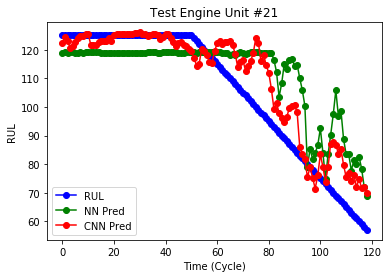

In [14]:
engineUnit = 21

X_test2, _ , _ = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_test, selected_features, time_window, 
                                                             'train', scaler=min_max_scaler, fit_transform=False, unit_number=engineUnit)
#X_test2, _ = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_test, selected_features, time_window, 'train', unit_Number=engineUnit)
#X_test2 = min_max_scaler.fit_transform(X_test2)

samplet2 = np.reshape(X_test2, newshape=(X_test2.shape[0], int(X_test2.shape[1]/nFeatures), nFeatures))

nnPred = modelRUL.predict(X_test2)
cnnPred = DCNN.predict(samplet2)

maxCycle = X_test2.shape[0]
faultCycle = y_test[engineUnit-1]
cycles = np.arange(maxCycle)
rulArray = np.arange(faultCycle, maxCycle+faultCycle)
rulArray[rulArray > constRUL] = constRUL
rulArray = np.flipud(rulArray)

#print(cycles)
#print(rulArray)

'''print("Testing data")
print(X_test2.shape)
print(X_test2[-5:,:])
print(nnPred)
print(cnnPred)'''

plotRUL(cycles, rulArray, nnPred, cnnPred, engineUnit)